In [748]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import lifelines
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

data = pd.read_csv("Obituaries_Dataset.csv")
data.head()

Name Announcement       Death      Burial  \
0              Eng. Paul Chemweno    11/8/2017   11/2/2017  11/17/2017   
1            Edith Kiende Kiogora    11/8/2017  10/27/2017  11/11/2017   
2     Simon Muchiri Ngigii Mbaria    11/8/2017   11/1/2017   11/8/2017   
3  Mwalimu Erick Namusasi Werunga    11/8/2017  10/24/2017   11/9/2017   
4            Catherine Mueni Sina    11/8/2017   11/2/2017  11/11/2017   

  Burial_Day Burial_Week  Gender   Age Color    Size        ...          \
0     Friday     Weekday    Male  66.0   Yes   55.18        ...           
1   Saturday     Weekend  Female  43.0   Yes   83.60        ...           
2  Wednesday     Weekday    Male  35.0   Yes  109.12        ...           
3   Thursday     Weekday    Male  54.0   Yes   83.60        ...           
4   Saturday     Weekend  Female  41.0    No   55.18        ...           

                       Morgue  Same_Morgue  Cost_Morgue  Occupation  \
0                MTRH Eldoret           No          NaN    Director   
1  Chogoria Hospital Mortuary           No          NaN     Teacher   
2                Umash Nakuru           No          NaN     Teacher   
3              Maida Mortuary          NaN          NaN     Teacher   
4                         NaN          NaN          NaN         NaN   

  Repetition Corporate Corporate_Name Residence Residence_Name  \
0        NaN       NaN            NaN       NaN            NaN   
1        NaN       NaN            NaN       NaN            NaN   
2        NaN       NaN            NaN       NaN            NaN   
3        NaN       NaN            NaN       NaN            NaN   
4        NaN       NaN            NaN       NaN            NaN   

  Residence_Category  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 39 columns]

## <font color='blue'> Question 1: Kaplan-Meier Survial Analysis <font>
Survival Analysis methods like Kaplan-Meier are used to give time until an event occurs, often referred to as death. In this case all the subjects are literally dead, thus features such as gender, colour, fundraising, spouse alive, spouse gender, do not contain death events that subjects are at a risk. A good example of a Kaplan-Meier application would have been, estimating the probability of users who in this case are alive of having a fundraiser at a specific age. 

## <font color='blue'> Question 2: Predict deaths that are likely to need a fundraising. </font>

In [749]:
for k, v in data.isnull().sum().items():
    print("percentage of missing values: {0}, {1}%".format(k, round(v/data.shape[0]*100, 2)))

print("old size {}".format(data.shape))
test_names = data[data['Fundraising'].isnull()]
test_names = test_names['Name']
data = data.drop(["Name"], axis=1)
data = data[[k for k, v in data.isnull().sum().items() if v/data.shape[0] < 0.8]]
print("new size {}".format(data.shape))

percentage of missing values: Name, 0.0%
percentage of missing values: Announcement, 2.01%
percentage of missing values: Death, 30.83%
percentage of missing values: Burial, 9.84%
percentage of missing values: Burial_Day, 9.91%
percentage of missing values: Burial_Week, 9.91%
percentage of missing values: Gender, 0.0%
percentage of missing values: Age, 60.73%
percentage of missing values: Color, 0.15%
percentage of missing values: Size, 4.18%
percentage of missing values: Word_Count, 4.18%
percentage of missing values: No_of_Children, 15.34%
percentage of missing values: Significant_Children, 15.41%
percentage of missing values: Significant_Relatives, 16.11%
percentage of missing values: Fundraising, 11.54%
percentage of missing values: Death_to_Announce, 0.0%
percentage of missing values: Death_to_Burial, 3.64%
percentage of missing values: Announce_to_Burial, 1.01%
percentage of missing values: No_of_Relatives, 17.82%
percentage of missing values: County_Burial, 19.13%
percentage of m

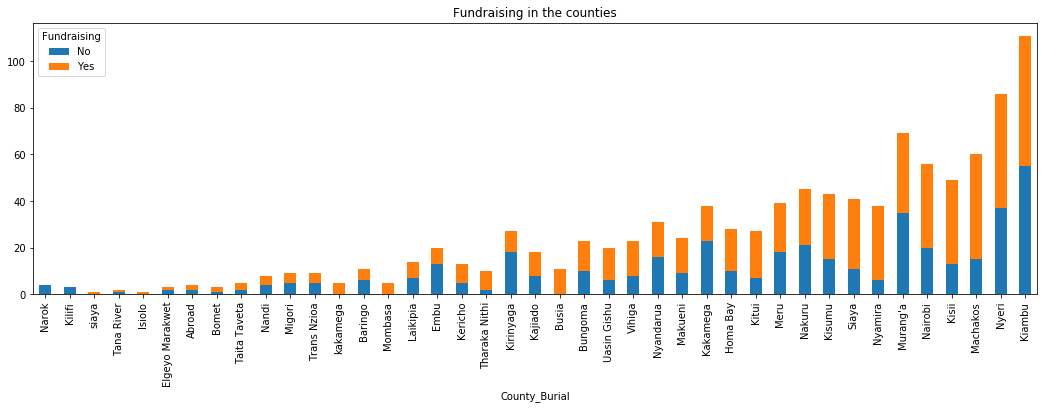

In [750]:
df = data[data['County_Burial'].notnull() & data['Fundraising'].notnull()]
tables = df.groupby(['County_Burial', 'Fundraising'])['Fundraising'].count()
tables = tables.unstack('Fundraising').fillna(0).sort_values("Yes", ascending=True)
tables.plot(kind='bar', stacked=True, figsize=(18, 5))
plt.title("Fundraising in the counties")
plt.show()

* The fundraised vs non-fundraised ratio seems to be almost equal accross the board, large  counties like kiambu have the biggest number of fundraisers. Death annoucements are dominated by the central Kenya counties.

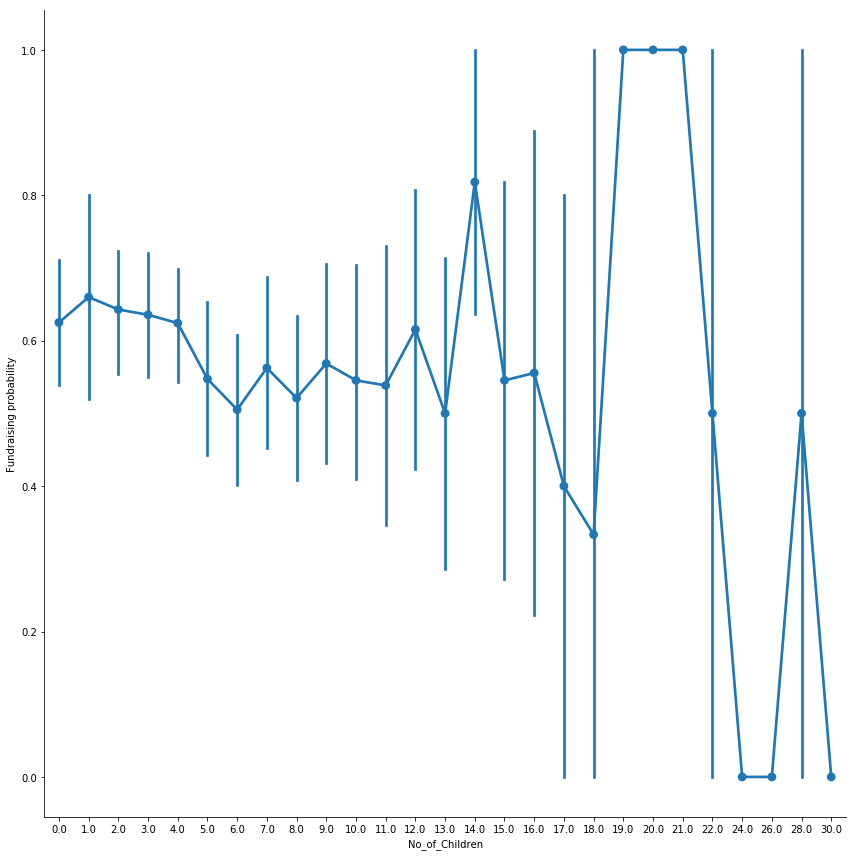

In [751]:
df = data[data['No_of_Children'].notnull() & data['Fundraising'].notnull()]
df['Fundraising'] = df['Fundraising'].map({"Yes": 1, "No":0})
g = sns.factorplot(x='No_of_Children', y='Fundraising', data=df, size=12)
g = g.set_ylabels('Fundraising probability')


* There is a decline in the number of fundraisers for families between 2 and 6, but from that point it is unpredictable at best. 

Text(0.5,0.98,'Fundraising by Age and gender')

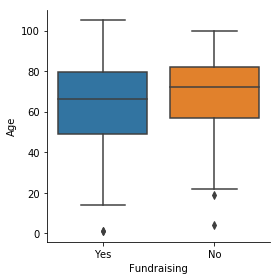

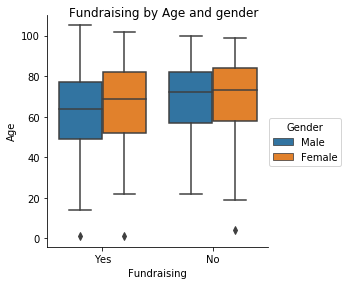

In [752]:
df = data[data['Age'].notnull() & data['Fundraising'].notnull() & data['Gender'].notnull()]
g = sns.factorplot(y='Age', x='Fundraising', data=df, kind='box')
g = sns.factorplot(y='Age', x='Fundraising', hue='Gender', data=df, kind='box')
g.fig.suptitle("Fundraising by Age and gender")

* As the age increases the number of fundraises  decrease

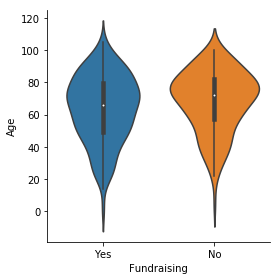

In [753]:
g = sns.factorplot(x='Fundraising', y='Age', data=df, kind='violin')

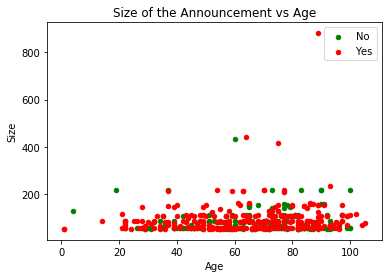

In [754]:
df = data[data['Fundraising'].notnull() & data['Age'].notnull() & data['Size'].notnull()]
colors = {"Yes": "red", "No": "green"}

fig, ax = plt.subplots()
grouped = df.groupby('Fundraising')
for key, group in grouped:
    group.plot(ax = ax, kind='scatter', x='Age', y="Size", label=key, color=colors[key])
plt.title("Size of the Announcement vs Age")
plt.show()

* Most announcement were below the size of 300, of the 4 biggest announcements, 3 of them fundraised

In [755]:
fund = data['Fundraising']
data = data[[k for k in data.columns if k != "Fundraising"]]

cols = list(data.columns)

all_cols = data.dtypes
obj_cols = [col for col in cols if not (all_cols[col] == "float64") ]

for x in obj_cols:
    data[x] = data[x].apply(lambda x: str(x))
    
for col in obj_cols:
    le = LabelEncoder()
    le.fit(data[col])
    data[col] = le.transform(data[col])
data.head()

Announcement  Death  Burial  Burial_Day  Burial_Week  Gender   Age  Color  \
0            16     49      21           0            1       1  66.0      1   
1            16     34      16           2            3       0  43.0      1   
2            16     42      37           6            1       1  35.0      1   
3            16     31      38           4            1       1  54.0      1   
4            16     49      16           2            3       0  41.0      0   

     Size  Word_Count   ...    County_Death  County_Morgue  Distance_Death  \
0   55.18          77   ...              34             47               0   
1   83.60         191   ...              23             42              36   
2  109.12         105   ...              29             30               0   
3   83.60          69   ...              36             44               0   
4   55.18          48   ...              34             51              67   

   Distance_Morgue  Cause_of_Death  Married  Spouse_Alive  Spouse_gender  \
0                0               6        1             2              0   
1                0               6        1             2              1   
2              159               6        1             2              0   
3              174               6        1             0              0   
4              174               2        2             3              1   

   Hospital  Morgue  
0        66     151  
1        83      33  
2        13     310  
3       131     157  
4       131     322  

[5 rows x 28 columns]

In [756]:
null_cols = data.isnull().sum().sort_values(ascending=True)

for k, v in null_cols.items():
    if not (v == 0) :
        train = data[data[k].notnull()]
        test = data[data[k].isnull()]
        
        y_train = train[k]    #try to filter those without nans
        x_train = train.drop(k, axis=1)
        
        x_test = test.drop(k, axis=1)        
        mod = xgb.XGBRegressor()
        mod.fit(x_train, y_train)
        
        pred = mod.predict(x_test)
        test[k] = pred
        
        data = pd.concat([train, test], axis=0, ignore_index=False)
        

In [757]:
data.sort_index(inplace=True)
data['Fundraising'] = fund

train = data[data['Fundraising'].notnull()]
test = data[data['Fundraising'].isnull()]

train['Fundraising'] = train['Fundraising'].map({"Yes":1, "No": 0})
y_train = train['Fundraising']
x_train = train.drop(['Fundraising'], axis=1)

x_test = test.drop('Fundraising', axis=1)
x_test.shape

(149, 28)

In [758]:
rs= 2
kfold=StratifiedKFold(n_splits=5, random_state=rs, shuffle=True)
classifiers = []
classifiers.append(SVC(random_state = rs))
classifiers.append(RandomForestClassifier(random_state=rs))
classifiers.append(ExtraTreesClassifier(random_state=rs))
classifiers.append(GradientBoostingClassifier(random_state=rs))
classifiers.append(xgb.XGBClassifier(seed=rs))
classifiers.append(KNeighborsClassifier())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, x_train, y=y_train, scoring='accuracy', cv=kfold))

cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValsMeans": cv_means, "CrossValerrors": cv_std, 
            "Alg": ["SVC", "RF", "ETC", "GB", "XGB", "KNN"]})
cv_res.sort_values("CrossValsMeans", ascending=False)


Alg  CrossValerrors  CrossValsMeans
4  XGB        0.016009        0.781941
3   GB        0.022194        0.771422
1   RF        0.020605        0.749607
2  ETC        0.017140        0.704916
5  KNN        0.027345        0.663699
0  SVC        0.001037        0.607708

In [765]:
#SELECT THE VALUE AT THE CENTER AS THE PARAMETER, set lowest and highest

rf = xgb.XGBClassifier(seed=3, max_depth=5)
rs = 3
kk = True

extra_best = rf
initial_starter = starter = extra_best.max_depth #starter should be same size as the best parameter
old_score = -100
previous_results = []
while kk :
    
    nn = extra_best.max_depth
    
    n_minus = nn - starter      
    n_minus_one = n_minus + starter/2
    n_minus_two = n_minus_one - starter/4
    n_plus = nn + starter
    n_plus_one = n_plus - starter/2
    n_plus_two = n_plus_one + starter/4
    optima = [n_minus,n_minus_two,n_minus_one, nn, n_plus_two,n_plus_one, n_plus]
    
    for i, x in enumerate(optima):
        #optima[i] = int(x)
        if (x < 1)| (x >10):
            optima[i] = np.random.randint(1,10)    #.randint(2, 10, 3) #.random(5)
        else:
            optima[i] = int(x)

    
    ex_param_grid = {
        "max_depth":optima
        
            }
    
    #set n_jobs for GridSearch to the numbers of cores to speed up
    extra = GridSearchCV(extra_best, param_grid=ex_param_grid, cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=rs), scoring='roc_auc', verbose=1)
    extra.fit(x_train, y_train)    
    extra_best_estimator = extra.best_estimator_
    new_score =  extra.best_score_
   
    
        
    vals = "{0}<={1}<={2}<={3}=>{4}=>{5}=>{6}".format(optima[0], optima[1], optima[2], optima[3], optima[4], optima[5], optima[6])
    
    print("parameters :{0}, score: {1}".format(vals, new_score))
    
    
    previous_results.append(new_score)
    if len(previous_results) == 7:
        previous_results.pop(0)
    
    if new_score > old_score:
        old_score = new_score
        extra_best = extra_best_estimator
        starter = nn
        
    elif new_score == old_score:
        new_starter = int(starter/2)
        
        if new_starter != starter:            
            starter = new_starter
                      
            #when there are all five previous results are same stop
            if (len(previous_results) == 5) & (len(set(previous_results)) == 1):
                print("Has shown no any improvement after 5 runs")
                kk = False         
        else:
            kk = False  
    else:
        kk = False
print("Processed finished with best parameter: {0}, score: {1}".format(nn, old_score))


Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.6s finished


parameters :8<=1<=2<=5=>8=>7=>10, score: 0.8642484071335299
Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.8s finished


parameters :5<=6<=7<=10=>4=>4=>9, score: 0.8676641945775164
Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.3s finished


parameters :4<=1<=1<=6=>2=>1=>1, score: 0.8676641945775164
Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.3s finished


parameters :1<=2<=3<=6=>9=>8=>7, score: 0.8676641945775164
Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.7s finished


parameters :4<=4<=5<=6=>7=>7=>8, score: 0.8676641945775164
Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.6s finished


parameters :5<=5<=5<=6=>6=>6=>7, score: 0.8676641945775164
Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.8s finished


parameters :6<=6<=6<=6=>6=>6=>6, score: 0.8676641945775164
Processed finished with best parameter: 6, score: 0.8676641945775164


In [766]:
xgbm = xgb.XGBClassifier(seed=7,max_depth=6, n_estimators=787)
xgbm.fit(x_train, y_train)
pred = xgbm.predict(x_test)
pred = [round(abs(x), 0) for x in pred]
sub = pd.DataFrame({"Name": test_names, "Fundraising": pred})
sub.to_csv("fund.csv")
print(pred[:9])

[1, 1, 1, 1, 0, 0, 0, 1, 0]
